In [ ]:
!pip install brian2
from skimage.util import img_as_float
from skimage.io import imread
import numpy as np
from skimage.transform import resize
from skimage.transform import rescale
from copy import copy
import pickle
import matplotlib
import os
from skimage.color import rgb2gray
from skimage.color import hsv2rgb
import random
import matplotlib.pyplot as plt
from brian2 import *
from IPython.display import clear_output
%matplotlib inline

imgDef = 128
receptiveFieldSize=int(imgDef/18) #initial 16
print(receptiveFieldSize-2)
C1num = len(range(0,imgDef-receptiveFieldSize,receptiveFieldSize-2))
print(C1num)
print(range(0,imgDef-receptiveFieldSize,receptiveFieldSize-2))

5
25
range(0, 121, 5)


In [ ]:
from scipy import ndimage as nd

def power_conv(image, kernel):
    # Normalize images for better comparison.
    image = (image - image.mean()) / image.std()
    return np.sqrt(nd.convolve(image, np.real(kernel), mode='nearest')**2 +
                   nd.convolve(image, np.imag(kernel), mode='nearest')**2)

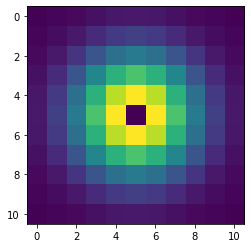

In [ ]:
# Local inhibition

def makeGaussian(size, fwhm = 3, center=None):
    """ Make a square gaussian kernel.

    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """

    x = np.arange(0, size, 1, dtype=float)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]

    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

kernelInhibition=makeGaussian(11, fwhm = 5)*1.15
kernelInhibition[5,5]=0

plt.figure()
plt.imshow(kernelInhibition)

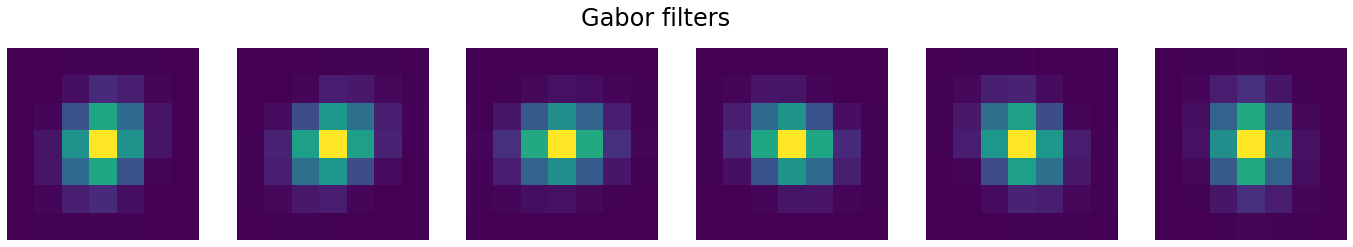

In [ ]:
from skimage.filters import gabor_kernel
#sigma_values = [4, 6, 8]
sigma_values = [1] #3  last try 1.5
frequency_values = [0.1] #0.2 last try 0..15
#frequency_values = [0.02, 0.05, 0.1]

kernels = []
for theta in range(6):
    theta = (theta / 6. + 1/8) * np.pi
    for sigma in sigma_values:
        for frequency in frequency_values:
            kernel = gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma)
            #print(kernel.shape)
            kernels.append(kernel)

cols = 6
rows = 1
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(24, 4))
fig.suptitle('Gabor filters', fontsize=24)
n=0

for y in range(0,cols):
        ax = axes[y]
        ax.imshow(np.real(kernels[n]), interpolation='none')
        n=n+1
        ax.axis('off')

In [ ]:
## Dataset Upload ##
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

specific_nums = []
for num in range(10):
  specific_nums.append(x_train[y_train == num])
objects = []

digits = 2
num_nums_specific = int((4000 + digits - 1) / digits)
for num in range(digits): #num of objects used in the input
    for numnum in range(num_nums_specific):
      objects.append(rescale(specific_nums[num][numnum], 128/28, multichannel=False))

print('Dataset contains {} pictures of {} digits'.format(len(objects), digits))

11501568/11490434 [==============================] - 0s 0us/step
Dataset contains 4000 pictures of 2 digits


In [ ]:
## S1 and C1 Layers ##
import progressbar

num_obj = 3501

single = False

#for cnt,img in enumerate([objects[num_obj]]):
for cnt in progressbar.progressbar(range(len(objects))):
    #print('Current file processing: ', cnt)
    if single:
      cnt = num_obj
    img = objects[cnt]
    if single:
      figG, axesG = plt.subplots(nrows=1, ncols=6, figsize=(24, 4))
      figG.suptitle('Gabor convolutions at different angles (S1 layer)', fontsize=24)
    spikes=np.zeros((imgDef,imgDef,6,len(sigma_values),len(frequency_values)))
    n=0
    for theta in range(6):
        for s,sigma in enumerate(sigma_values):
            for f,frequency in enumerate(frequency_values):
                spikes[:,:,theta,s,f]=resize(power_conv(img,kernels[n]), (imgDef, imgDef)) #convolutions for all thetas, sigmas, f
                if single:
                  ax = axesG[n]
                  ax.imshow(spikes[:,:,theta,s,f], interpolation='none')
                  ax.axis('off')
                n+=1
    
    #S1valmax = np.max(spikes)
    #print()
    #print(S1valmax)
    #print()

    S1ori=np.argmax(spikes, axis=2) #number of orientation propagated (C1xC1xsxf)
    S1val=np.max(spikes, axis=2) #value at this orientation
    S1ori[S1val < 0.5 * np.max(S1val)] = -1 #EDIT to cancel out cells where actually nothing but they still got some orientation (3e-1)
    #print(S1val.shape)
    C1ori=np.zeros([C1num,C1num,len(sigma_values),len(frequency_values)])
    C1lat=np.zeros([C1num,C1num,len(sigma_values),len(frequency_values)])
    if single:
      fig1, axes1 = plt.subplots(nrows=len(frequency_values), ncols=len(sigma_values), figsize=(5, 3))
      fig1.suptitle('C1 Layer - Orientation #'+str(cnt), fontsize=12);n=0
      fig2, axes2 = plt.subplots(nrows=len(frequency_values), ncols=len(sigma_values), figsize=(5, 3))
      fig2.suptitle('C1 Layer - Latency before lateral inhibition#'+str(cnt), fontsize=12);n=0
      fig3, axes3 = plt.subplots(nrows=len(frequency_values), ncols=len(sigma_values), figsize=(5, 3))
      fig3.suptitle('C1 Layer - Latency after lateral inhibition#'+str(cnt), fontsize=12);n=0
    for s,sigma in enumerate(sigma_values):
        for f,frequency in enumerate(frequency_values):
            for x,px in enumerate(range(0,imgDef-receptiveFieldSize,receptiveFieldSize-2)):
                for y,py in enumerate(range(0,imgDef-receptiveFieldSize,receptiveFieldSize-2)):
                    fstSpX,fstSpY=np.unravel_index(np.argmax(S1val[px:(px+receptiveFieldSize),py:(py+receptiveFieldSize),s,f]),(receptiveFieldSize,receptiveFieldSize))
                    C1ori[x,y,s,f]=S1ori[px+fstSpX,py+fstSpY,s,f]
                    v=S1val[px+fstSpX,py+fstSpY,s,f]
                    #print(1/v)
                    if v==0:
                        C1lat[x,y,s,f]=np.nan
                        C1ori[x,y,s,f]=np.nan
                    else:
                        C1lat[x,y,s,f]=1/v
            if single:
              ax1 = axes1#[f][s]
              im1=ax1.imshow(C1ori[:,:,s,f])#, vmin=0, vmax=6,interpolation='none')
              ax1.axis('off');
              ax2 = axes2#[f][s]
              im2=ax2.imshow(C1lat[:,:,s,f], vmin=0,interpolation='none')
              ax2.axis('off');n+=1
    if single:
      fig1.subplots_adjust(right=0.8)
      cbar_ax = fig1.add_axes([0.85, 0.15, 0.05, 0.7])
      fig1.colorbar(im1, cax=cbar_ax)
      fig2.subplots_adjust(right=0.8)
      cbar_ax = fig2.add_axes([0.85, 0.15, 0.05, 0.7])
      fig2.colorbar(im2, cax=cbar_ax)
    
    flag_inhib = False
    
    #print('Total number of neurons needed: '+str(np.prod(C1ori.shape)*6))
    #print('Size of C1 layer: '+str(C1ori.reshape((C1num, C1num, len(sigma_values)*len(frequency_values))).shape))
    #print('Image reduction by a 1/'+str((imgDef**2)/(C1num**2))+' ratio.')
    
    for s,sigma in enumerate(sigma_values):
        for f,frequency in enumerate(frequency_values):
            tmp2=copy(C1lat[:,:,s,f])
            #print(np.amax(C1lat[:,:,s,f]))
            for ori in range(6):
                tmp=np.zeros((C1num,C1num))
                ori_indices = (C1ori[:,:,s,f]==ori)
                tmp[ori_indices] = 1 # binary array: whether it is current orientation or not
                tmp=nd.convolve(tmp, kernelInhibition, mode='wrap') #, mode='constant', cval=0.0)
                tmp2[ori_indices] = clip(tmp2[ori_indices] * tmp[ori_indices], tmp2[ori_indices], None)
            if not flag_inhib:
                C1lat[:,:,s,f]=copy(tmp2)
                flag_inhib = True
                #print(np.amax(C1lat[:,:,s,f]), np.amax(tmp2))
            if single:
              ax3 = axes3#[f][s]
              im3=ax3.imshow(C1lat[:,:,s,f], vmin=0,interpolation='none')
              ax3.axis('off');
              fig3.subplots_adjust(right=0.8)
              cbar_ax = fig3.add_axes([0.85, 0.15, 0.05, 0.7])
              fig3.colorbar(im3, cax=cbar_ax)

    
    ## Saving the C1 layer for the first Gabor filter ##
    
    C1 = np.zeros([C1num, C1num, 6])
    for ori in range(6):
        tmp=np.zeros((C1num,C1num))
        tmp2=copy(C1lat[:,:,0,0])
        tmp[np.nonzero(C1ori[:,:,0,0]==ori)] = tmp2[np.nonzero(C1ori[:,:,0,0]==ori)]
        C1[:, :, ori] = copy(tmp)
    
    if single:    
      cols = 6
      n = 0
      fig4, axes4 = plt.subplots(nrows=1, ncols=cols, figsize=(24, 4))
      fig4.suptitle('C1 Layer sparse, orientations - Latency after lateral inhibition#'+str(cnt), fontsize=24)
      for y in range(cols):
          ax4 = axes4[y]
          ax4.imshow(C1[:, :, n], vmin=0, interpolation='none')
          ax4.axis('off');
          n+=1
        
    ## Saving the objects: ##
    
    if not single:
      with open('mnist_C1_{}.pickle'.format(cnt), 'wb') as f:
          pickle.dump([C1, C1num], f)
          # print('file mnist_C1_{}.pickle is saved'.format(cnt))
    
    if single:
      break

100% (4000 of 4000) |####################| Elapsed Time: 0:02:00 Time:  0:02:00


In [ ]:
## Data preprocessing for S2 input ##
import progressbar
from random import shuffle

i_neur = []
t_neur = []

dur = num_nums_specific * digits #number of images in the input sequence
spikes_dur = 250 #duration of a spike train for 1 picture (in ms) best - 250 ! last 62.5
pic_dur = spikes_dur * 2 #total time slot for 1 picture (in ms)


count = np.arange(dur)
shuffle(count)
print(len(count))
print(count)

per = np.empty((len(count)))

z = 0
for indx, cnt in enumerate(count):
    if indx % (len(count) // 20) == 0:
        print('Picture {} out of {}'.format(indx, len(count)))
    with open(os.path.join('mnist_C1_{}.pickle'.format(int(cnt))), 'rb') as f:
        C1, C1num = pickle.load(f)

        indices = array(range(0,C1num**2*6)) #indices of 6 arrays 25x25 for each orientation (flattened)

        times = array(C1.reshape((np.prod(C1.shape)))) / 1. #EDIT shrinking the spike train for correct STDP !

        per[indx] = np.percentile(times[times > 0], 99) 
        #print(indx, np.percentile(times[times > 0], 80)) #about 20-50 ms

        times[times > spikes_dur] = 0 #to cut the spikes with too large latency (larger than 500 ms)

        j = 0
        while j < len(times):
            if times[j] == 0:
                times = np.delete(times, j)
                indices = np.delete(indices, j)
                j -= 1
            j+=1

        i_neur = np.concatenate([i_neur, indices])
        t_neur = np.concatenate([t_neur, times + z * pic_dur])
        z+=1
        if z >= dur:
            break
            
print('Number of pictures: ', z)

t_neur = t_neur * ms
print('Size of the input arrays: ', t_neur.shape, i_neur.shape)
print('Unique neuron indices firing: ', len(np.unique(i_neur)))
print('Total number of neurons: ', C1num**2 * 6)

# for cnt in range(10):
#   print(np.mean(per[:int(len(count) / 10) * (cnt + 1)]), len(per[:int(len(count) / 10) * (cnt + 1)]))

4000
[ 451 2521 3466 ... 3436  137 1904]
Picture 0 out of 4000
Picture 200 out of 4000
Picture 400 out of 4000
Picture 600 out of 4000
Picture 800 out of 4000
Picture 1000 out of 4000
Picture 1200 out of 4000
Picture 1400 out of 4000
Picture 1600 out of 4000
Picture 1800 out of 4000
Picture 2000 out of 4000
Picture 2200 out of 4000
Picture 2400 out of 4000
Picture 2600 out of 4000
Picture 2800 out of 4000
Picture 3000 out of 4000
Picture 3200 out of 4000
Picture 3400 out of 4000
Picture 3600 out of 4000
Picture 3800 out of 4000
Number of pictures:  4000
Size of the input arrays:  (510253,) (510253,)
Unique neuron indices firing:  2640
Total number of neurons:  3750


WARNING    "i" is an internal variable of group "synapses_6", but also exists in the run namespace with the value 3749. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Total teporal length of the full dataset: 2000.0 sec.
Total training time: 400.0 sec.


WARNING    "i" is an internal variable of group "synapses", but also exists in the run namespace with the value 3749. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "j" is an internal variable of group "synapses_7", but also exists in the run namespace with the value 9. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "i" is an internal variable of group "synapses_7", but also exists in the run namespace with the value 3749. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Synapses with STDP:  37500


WARNING    "v" is an internal variable of group "neurongroup_4", but also exists in the run namespace with the value 0.27252896368891494. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "s" is an internal variable of group "synapses_7", but also exists in the run namespace with the value 0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 200. s
3.7223 s (1%) simulated in 10s, estimated 8m 47s remaining.
7.4833 s (3%) simulated in 20s, estimated 8m 35s remaining.
11.2311 s (5%) simulated in 30s, estimated 8m 24s remaining.
15.002 s (7%) simulated in 40s, estimated 8m 13s remaining.
18.7051 s (9%) simulated in 50s, estimated 8m 5s remaining.
22.4286 s (11%) simulated in 1m 0s, estimated 7m 55s remaining.
26.133 s (13%) simulated in 1m 10s, estimated 7m 46s remaining.
29.8775 s (14%) simulated in 1m 20s, estimated 7m 36s remaining.
33.6202 s (16%) simulated in 1m 30s, estimated 7m 25s remaining.
37.3632 s (18%) simulated in 1m 40s, estimated 7m 15s remaining.
41.1183 s (20%) simulated in 1m 50s, estimated 7m 5s remaining.
44.8552 s (22%) simulated in 2m 0s, estimated 6m 55s remaining.
48.5852 s (24%) simulated in 2m 10s, estimated 6m 45s remaining.
52.3254 s (26%) simulated in 2m 20s, estimated 6m 35s remaining.
56.0586 s (28%) simulated in 2m 30s, estimated 6m 25s remaining

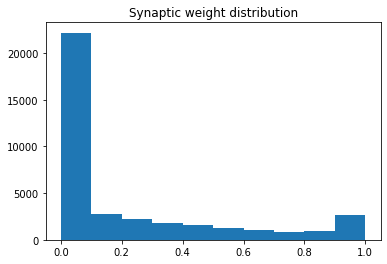

(25, 25) (25, 25) (25, 25)


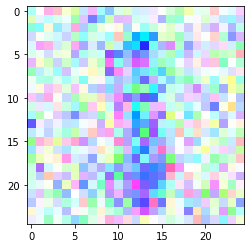

(25, 25) (25, 25) (25, 25)


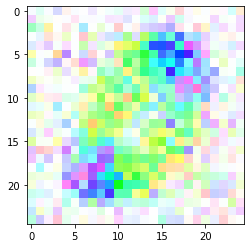

(25, 25) (25, 25) (25, 25)


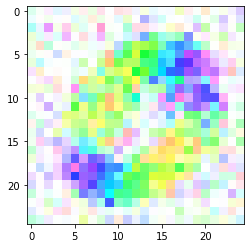

(25, 25) (25, 25) (25, 25)


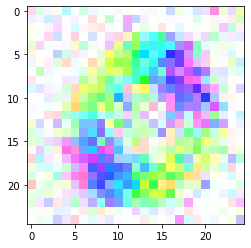

(25, 25) (25, 25) (25, 25)


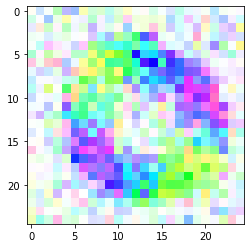

(25, 25) (25, 25) (25, 25)


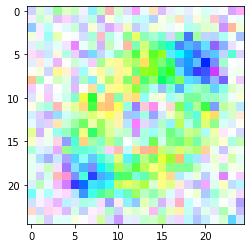

(25, 25) (25, 25) (25, 25)


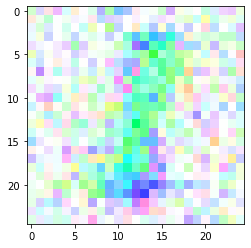

(25, 25) (25, 25) (25, 25)


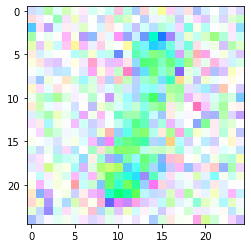

(25, 25) (25, 25) (25, 25)


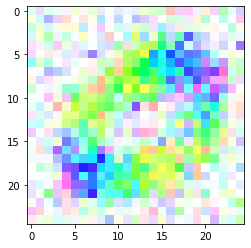

(25, 25) (25, 25) (25, 25)


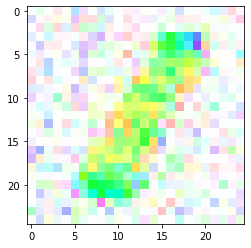

time passed: 300 sec
Starting simulation at t=200. s for a duration of 200. s
3.831 s (1%) simulated in 10s, estimated 8m 32s remaining.
7.6445 s (3%) simulated in 20s, estimated 8m 23s remaining.
11.5043 s (5%) simulated in 30s, estimated 8m 12s remaining.
15.3716 s (7%) simulated in 40s, estimated 8m 0s remaining.
19.2239 s (9%) simulated in 50s, estimated 7m 50s remaining.
23.0699 s (11%) simulated in 1m 0s, estimated 7m 40s remaining.
26.9058 s (13%) simulated in 1m 10s, estimated 7m 30s remaining.
30.749 s (15%) simulated in 1m 20s, estimated 7m 20s remaining.
34.5807 s (17%) simulated in 1m 30s, estimated 7m 11s remaining.
38.3677 s (19%) simulated in 1m 40s, estimated 7m 1s remaining.
42.1847 s (21%) simulated in 1m 50s, estimated 6m 52s remaining.
45.9934 s (22%) simulated in 2m 0s, estimated 6m 42s remaining.
49.7833 s (24%) simulated in 2m 10s, estimated 6m 32s remaining.
53.5989 s (26%) simulated in 2m 20s, estimated 6m 22s remaining.
57.401 s (28%) simulated in 2m 30s, esti

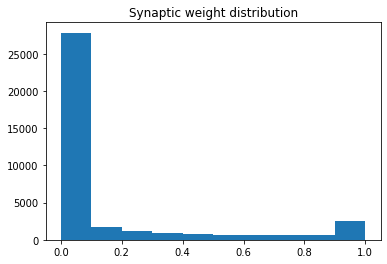

(25, 25) (25, 25) (25, 25)


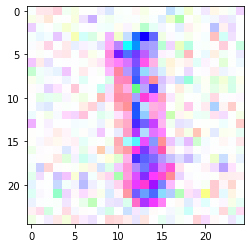

(25, 25) (25, 25) (25, 25)


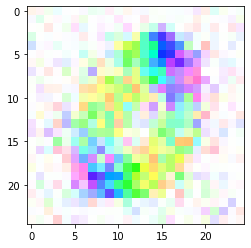

(25, 25) (25, 25) (25, 25)


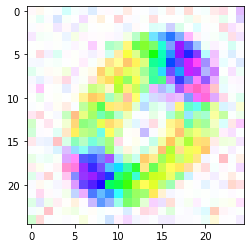

(25, 25) (25, 25) (25, 25)


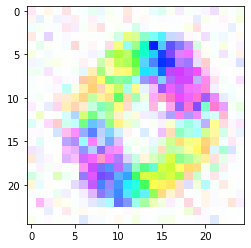

(25, 25) (25, 25) (25, 25)


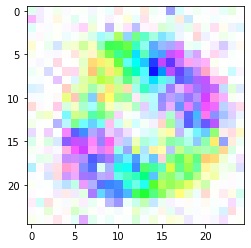

(25, 25) (25, 25) (25, 25)


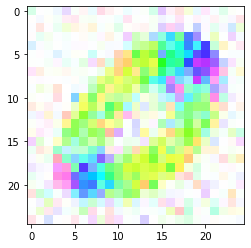

(25, 25) (25, 25) (25, 25)


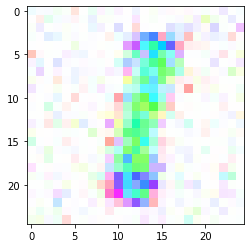

(25, 25) (25, 25) (25, 25)


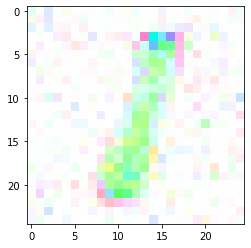

(25, 25) (25, 25) (25, 25)


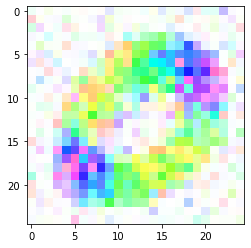

(25, 25) (25, 25) (25, 25)


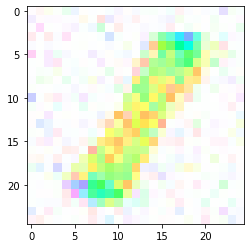

time passed: 600 sec


In [ ]:

## S2 Layer ##

freq = 8 * Hz
amp_mod = 2 * mV #1!

## Parameters
simulation_duration =  pic_dur / 1000 * dur * second #duration in seconds
print('Total teporal length of the full dataset: {} sec.'.format(simulation_duration))

# we can train on the whole dataset but 400 seconds is enough.
batch_step = 200 * second
step_num = 2
print('Total training time: {} sec.'.format(batch_step*step_num))

PoissonFreq = 0.8 #0.8
S2Inhibition = -25 * mV #15

## Neurons
taum = 10 * ms
Ee = 0 * mV
vt = -54 * mV
vr = -60 * mV
El = -74 * mV
taue = 5 * ms

## STDP
taupre = 100 * ms #initially 20 (!!!last good 100, 250ms)    last (15, -25, 62.5ms, 40ms, .05, .01 - fair) ((1, -15!), (2, -25!!), 62.5ms, 40ms, .05, .01 - good)
taupost = taupre
gmax = .05 #initially .01, but tweaked a little (!!0.05)
dApre = .02 #initially .01      (!!last good 0.02)
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax

# Setting the stage
network = Network()

## Stimuli section
num_neurons = 10

input_n = NeuronGroup(C1num**2 * 6, 'spike : 1', threshold='spike>0', reset='spike=0')
input_n.spike = 0

input_spikes = SpikeGeneratorGroup(C1num**2 * 6, i_neur, t_neur)
stimulus = TimedArray(np.tile([PoissonFreq, PoissonFreq, 0., 0.], dur)*Hz, dt=spikes_dur/2*ms)
input_Poisson = PoissonGroup(C1num**2 * 6, rates='stimulus(t)')

network.add(input_n)
network.add(input_spikes)
network.add(input_Poisson)

S_sp = Synapses(input_spikes, input_n, on_pre='spike+=1')
S_sp.connect(j='i')
network.add(S_sp)

S_poi = Synapses(input_Poisson, input_n, on_pre='spike+=1')
S_poi.connect(j='i')
network.add(S_poi)

neurons = NeuronGroup(num_neurons, '''dv/dt = (ge * (Ee-vr) + El - v + amp_mod * cos(2 * pi * (freq * t - 14/16))) / taum : volt
                                      dge/dt = -ge / taue : 1''',
                      threshold='v>vt', reset='v = vr',
                      method='euler')
neurons.v = vr
network.add(neurons)


S = Synapses(input_n, neurons,
             '''w : 1
                dApre/dt = -Apre / taupre : 1 (event-driven)
                dApost/dt = -Apost / taupost : 1 (event-driven)''',
             on_pre='''ge += w
                    Apre += dApre
                    w = clip(w + Apost, 0, gmax)''',
             on_post='''Apost += dApost
                     w = clip(w + Apre, 0, gmax)''',
             )
S.connect(p=1.0)
#visualise_connectivity(S)

k = 0
for i, j in zip(S.i, S.j):
    k += 1
print('Synapses with STDP: ', k) #number of synapses

#S.w = '((rand() * 0.1) + 0.45) * gmax'
#S.w = '0.01*gmax'
smean = 0.7
S.w = clip(np.random.normal(gmax * smean, gmax*0.1 / 5, size=k), (smean - 0.05) * gmax, (smean + 0.05) * gmax) #0.5 last (0.7!!)

network.add(S)

S_in = Synapses(neurons, neurons,
                   model='''s: volt''',
                   on_pre='v_post += s')
S_in.connect(condition='i!=j')# and i!=(j + 1)%num_neurons') #change back to i!=j
#S_in.connect(p = 0.8, condition='i!=j')
#visualise_connectivity(S_in)
S_in.s = S2Inhibition

network.add(S_in)

syn_i = np.linspace(0, k-1, k)
#print(syn_i[::10]) #synapses for S2 cell #0



## synapses from cell (2, 2) orientation 0 ##
synapse_monitor = StateMonitor(S, 'w', record=True, dt=1*second) 
network.add(synapse_monitor)

mon = SpikeMonitor(neurons, ['v'], record=True)
network.add(mon)


for time in range(step_num):
  network.run(batch_step, report='text')
  plt.hist(S.w / gmax)
  plt.title("Synaptic weight distribution")
  show()
  
  for cnt in range(num_neurons):  
      cell = S.w[cnt::num_neurons]
      cell = np.reshape(cell, (C1num, C1num, 6))
      cell_complex = np.zeros((C1num, C1num), dtype=complex)
      for theta in range(6):
        cell_complex += cell[:, :, theta] * np.exp(1j * (theta / 6. + 1/8) * np.pi)
      hue = np.angle(cell_complex)
      hue = np.interp(hue, (hue.min(), hue.max()), (0, 1))
      saturation = abs(cell_complex)
      saturation = np.interp(saturation, (saturation.min(), saturation.max()), (0, 1))
      value = np.ones((C1num, C1num))
      print(hue.shape, saturation.shape, value.shape)
      image = np.zeros((C1num, C1num, 3))
      for cnt1 in range(C1num):
        for cnt2 in range(C1num):
          image[cnt1][cnt2][0] = hue[cnt1][cnt2]
          image[cnt1][cnt2][1] = saturation[cnt1][cnt2]
          image[cnt1][cnt2][2] = value[cnt1][cnt2]
      image = hsv2rgb(image)
      imshow(image, interpolation='none')
      show()
  print('time passed: {} sec'.format((time + 1) * 300))

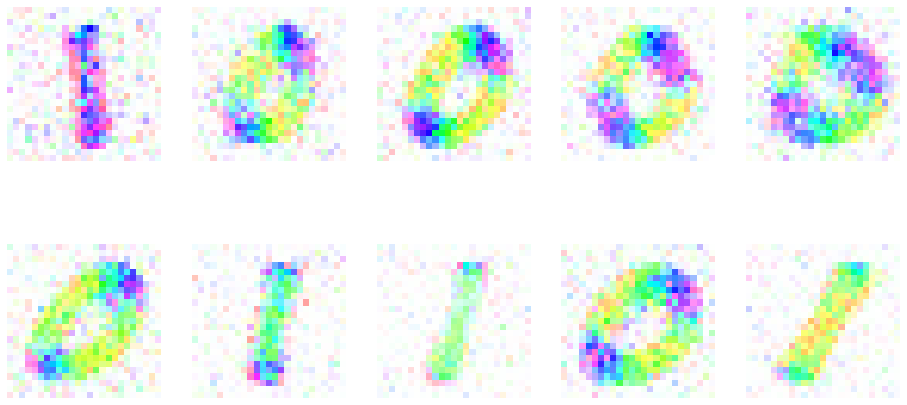

In [ ]:
HSV = True

if not HSV:
    imgs = np.zeros((10, C1num, C1num))
    print(imgs.shape)
    for cnt in range(10):  
        cell = Sw[cnt::10]
        cell = cell.reshape(C1num, C1num, 6)
        img = np.mean(cell, axis=2)
        imgs[cnt, :, :] = img
else:
    imgs = np.zeros((num_neurons, C1num, C1num, 3))
    for cnt in range(num_neurons):  
        cell = S.w[cnt::num_neurons]
        cell = np.reshape(cell, (C1num, C1num, 6))
        cell_complex = np.zeros((C1num, C1num), dtype=complex)
        for theta in range(6):
            cell_complex += cell[:, :, theta] * np.exp(1j * (theta / 6. + 1/8) * np.pi)
        hue = np.angle(cell_complex)
        hue = np.interp(hue, (hue.min(), hue.max()), (0, 1))
        saturation = abs(cell_complex)
        saturation = np.interp(saturation, (saturation.min(), saturation.max()), (0, 1))
        value = np.ones((C1num, C1num))
        image = np.zeros((C1num, C1num, 3))
        for cnt1 in range(C1num):
            for cnt2 in range(C1num):
                image[cnt1][cnt2][0] = hue[cnt1][cnt2]
                image[cnt1][cnt2][1] = saturation[cnt1][cnt2]
                image[cnt1][cnt2][2] = value[cnt1][cnt2]
        image = hsv2rgb(image)
        imgs[cnt, :, :, :] = image
    
cols = 5
rows = 2
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(16, 8))
# fig.suptitle('S2 patterns', fontsize=24)
n=0
for x in range(0,rows):
    for y in range(0,cols):
        ax = axes[x][y]
        im = ax.imshow(imgs[n], vmin = imgs[n].min(), vmax=imgs[n].max(), interpolation='none', cmap='binary')
        n=n+1
        ax.axis('off')
        if n - 1 > num_neurons:
          break
    if n - 1 > num_neurons:
        break

savefig('1d.pdf', dpi = 600)

[0 0 0 0 1 0 1 0 1 0 1 1 1 1 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0]


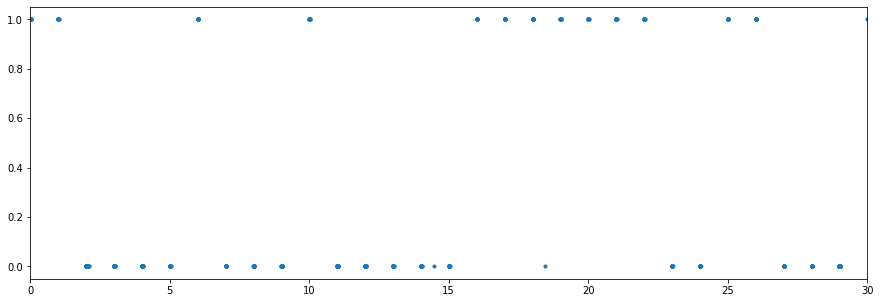

In [ ]:
num_image = 2000
total_images = 1.1
a = pic_dur * (num_image - 0.01)/1000
b = a + (spikes_dur + pic_dur * (total_images - 1))/1000
figure(figsize=(15, 5))

# Manually written numbers of cells that "recognize" a digit 0
# has to be edited every time
zrs = [1, 2, 3, 4, 5, 8]

mon_new_i = [i not in zrs for i in mon.i]
mon_new_t = mon.t/second*2 - step_num*batch_step/second


mon_new_t = mon_new_t[mon_new_t > 0]
mon_new_i = mon_new_i[-len(mon_new_t):]
plot(mon_new_t, mon_new_i, '.')

xlim(0, 30)
labels_export = count[2000:]//num_nums_specific
print(labels_export[:30])

file = 'spikes_for_global_alt.pickle'
with open(file, 'wb') as f:
           pickle.dump([mon_new_t, mon_new_i, labels_export], f)

show()

In [ ]:
## A network to test the output from a single image after the Hebbian Learning ##
specific_nums_valid = []
for num in range(10):
  specific_nums_valid.append(x_train[y_train == num])
valid = []

digits_valid = digits
num_nums_specific_valid = int(100 / digits_valid)
for num in range(digits_valid): #num of objects used in the input
    for numnum in range(num_nums_specific_valid):
      valid.append(rescale(specific_nums[num][numnum + 1000], 128/28, multichannel=False))
    
for cnt in progressbar.progressbar(range(len(valid))):
    #print('Current file processing: ', cnt)
    img = valid[cnt]
    spikes=np.zeros((imgDef,imgDef,6,len(sigma_values),len(frequency_values)))
    n=0
    for theta in range(6):
        for s,sigma in enumerate(sigma_values):
            for f,frequency in enumerate(frequency_values):
                spikes[:,:,theta,s,f]=resize(power_conv(img,kernels[n]), (imgDef, imgDef)) #convolutions for all thetas, sigmas, f
                n+=1
    S1ori=np.argmax(spikes, axis=2) #number of orientation propagated (C1xC1xsxf)
    S1val=np.max(spikes, axis=2) #value at this orientation
    S1ori[S1val < 3e-1 * np.max(S1val)] = -1 #EDIT to cancel out cells where actually nothing but they still got some orientation
    #print(S1val.shape)
    C1ori=np.zeros([C1num,C1num,len(sigma_values),len(frequency_values)])
    C1lat=np.zeros([C1num,C1num,len(sigma_values),len(frequency_values)])
    for s,sigma in enumerate(sigma_values):
        for f,frequency in enumerate(frequency_values):
            for x,px in enumerate(range(0,imgDef-receptiveFieldSize,receptiveFieldSize-2)):
                for y,py in enumerate(range(0,imgDef-receptiveFieldSize,receptiveFieldSize-2)):
                    fstSpX,fstSpY=np.unravel_index(np.argmax(S1val[px:(px+receptiveFieldSize),py:(py+receptiveFieldSize),s,f]),(receptiveFieldSize,receptiveFieldSize))
                    C1ori[x,y,s,f]=S1ori[px+fstSpX,py+fstSpY,s,f]
                    v=S1val[px+fstSpX,py+fstSpY,s,f]
                    #print(1/v)
                    if v==0:
                        C1lat[x,y,s,f]=np.nan
                        C1ori[x,y,s,f]=np.nan
                    else:
                        C1lat[x,y,s,f]=1/v
    
    flag_inhib = False
    
    for s,sigma in enumerate(sigma_values):
        for f,frequency in enumerate(frequency_values):
            tmp2=copy(C1lat[:,:,s,f])
            #print(np.amax(C1lat[:,:,s,f]))
            for ori in range(6):
                tmp=np.zeros((C1num,C1num))
                ori_indices = (C1ori[:,:,s,f]==ori)
                tmp[ori_indices] = 1 # binary array: whether it is current orientation or not
                tmp=nd.convolve(tmp, kernelInhibition, mode='wrap') #, mode='constant', cval=0.0)
                tmp2[ori_indices] = clip(tmp2[ori_indices] * tmp[ori_indices], tmp2[ori_indices], None)
            if not flag_inhib:
                C1lat[:,:,s,f]=copy(tmp2)
                flag_inhib = True
                #print(np.amax(C1lat[:,:,s,f]), np.amax(tmp2))
    
    ## Saving the C1 layer for the first Gabor filter ##
    
    C1 = np.zeros([C1num, C1num, 6])
    for ori in range(6):
        tmp=np.zeros((C1num,C1num))
        tmp2=copy(C1lat[:,:,0,0])
        tmp[np.nonzero(C1ori[:,:,0,0]==ori)] = tmp2[np.nonzero(C1ori[:,:,0,0]==ori)]
        C1[:, :, ori] = copy(tmp)
        
    ## Saving the objects: ##
    with open('valid_C1_{}.pickle'.format(cnt), 'wb') as f:
        pickle.dump([C1, C1num], f)


i_neur_valid = []
t_neur_valid = []

dur_valid = num_nums_specific_valid * digits_valid #number of images in the input sequence


z = 0
for cnt in range(len(valid)):
    with open(os.path.join('valid_C1_{}.pickle'.format(int(cnt))), 'rb') as f:
        C1, C1num = pickle.load(f)

        indices = array(range(0,C1num**2*6)) #indices of 6 arrays 25x25 for each orientation (flattened)

        times = array(C1.reshape((np.prod(C1.shape)))) / 1. #EDIT shrinking the spike train for correct STDP
        #print(np.percentile(times[times > 0], 99)) #about 1000 ms (80th percentile): reducing factor 1000 ms/20 ms = 50

        times[times > spikes_dur] = 0 #to cut the spikes with too large latency (larger than 500 ms)
        
        j = 0
        while j < len(times):
            if times[j] == 0:
                times = np.delete(times, j)
                indices = np.delete(indices, j)
                j -= 1
            j+=1
        
        i_neur_valid = np.concatenate([i_neur_valid, indices])
        t_neur_valid = np.concatenate([t_neur_valid, times + z * pic_dur])
        z+=1
        if z >= dur:
            break

t_neur_valid = t_neur_valid * ms
        
test = Network()

input_test = SpikeGeneratorGroup(C1num**2 * 6, i_neur_valid, t_neur_valid)
test.add(input_test)

neurons_test = NeuronGroup(num_neurons, 
                           '''dv/dt = (ge * (Ee-vr) + El - v) / taum : volt
                                      dge/dt = -ge / taue : 1''',
                      threshold='v>vt', reset='v = vr',
                      method='linear')
neurons_test.v = vr
test.add(neurons_test)

S_test = Synapses(input_test, neurons_test, '''w : 1''', on_pre='''ge += w''')
S_test.connect(p=1.0)
S_test.w = S.w
test.add(S_test)


accuracy = 0
accuracy_b = 0
S2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
cells = []
for cnt in range(len(valid)):
  mon_test = SpikeMonitor(neurons_test, ['v'], record=True)
  test.add(mon_test)
  test.run(pic_dur * ms)
  if cnt % 10 == 0:
    print()

  print('cell #{}, activated cell #: {}, correct answer: {}'.format(mon_test.i[0], S2[mon_test.i[0]], cnt // num_nums_specific_valid))
  cells.append(mon_test.i[0])
  if S2[mon_test.i[0]] == cnt // num_nums_specific_valid:
    accuracy += 1
  del mon_test

accuracy /= len(valid)
print('Accuracy: {}%'.format(accuracy * 100))

100% (100 of 100) |######################| Elapsed Time: 0:00:03 Time:  0:00:03
WARNING    "v" is an internal variable of group "neurongroup_5", but also exists in the run namespace with the value 0.4001663060510594. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]



cell #4, activated cell #: 4, correct answer: 0
cell #5, activated cell #: 5, correct answer: 0
cell #4, activated cell #: 4, correct answer: 0
cell #3, activated cell #: 3, correct answer: 0
cell #2, activated cell #: 2, correct answer: 0
cell #5, activated cell #: 5, correct answer: 0
cell #5, activated cell #: 5, correct answer: 0
cell #5, activated cell #: 5, correct answer: 0
cell #5, activated cell #: 5, correct answer: 0
cell #4, activated cell #: 4, correct answer: 0

cell #5, activated cell #: 5, correct answer: 0
cell #2, activated cell #: 2, correct answer: 0
cell #5, activated cell #: 5, correct answer: 0
cell #4, activated cell #: 4, correct answer: 0
cell #5, activated cell #: 5, correct answer: 0
cell #4, activated cell #: 4, correct answer: 0
cell #2, activated cell #: 2, correct answer: 0
cell #2, activated cell #: 2, correct answer: 0
cell #3, activated cell #: 3, correct answer: 0
cell #2, activated cell #: 2, correct answer: 0

cell #4, activated cell #: 4, correct

In [ ]:
count1 = np.empty((10), dtype=int)
count2 = np.empty((10), dtype=int)
for i in range(10):
  count1[i] = cells[:50].count(i)
  count2[i] = cells[50:].count(i)
print('Legit Accuracy: {}%'.format(100 - np.sum(np.minimum(count1, count2))))

Legit Accuracy: 94%
